# Train segmentation GAN (step2)

In [1]:
import os
import re
import numpy as np
import pandas as pd
import skimage
import skimage.io
import time

from torch.utils.data import DataLoader

# 1) Load data

In [2]:
# labeled train/val ids
he_labeled_folder_image = "../data/HE_labeled/img"
he_labeled_folder_mask = "../data/HE_labeled/mask-ps"
he_labeled_train = pd.read_csv("../data/HE_labeled/train.txt", sep='.png', header=None)[0].values.tolist()
he_labeled_train = [x+".png" for x in he_labeled_train if not re.match(r'\*|#', x)]
he_labeled_val = pd.read_csv("../data/HE_labeled/val.txt", sep='.png', header=None)[0].values.tolist()
he_labeled_val = [x+".png" for x in he_labeled_val if not re.match(r'\*|#', x)]
print("No. labeled train samples = %s" % len(he_labeled_train))
print("No. labeled validation samples = %s" % len(he_labeled_val))

# unlabeled he
he_unlabeled_folder = "../data/HE_unlabeled_40X/"
he_unlabeled = [_ for _ in os.listdir(he_unlabeled_folder) if _.endswith(".png")]

# unlabeled ihc (h channel)
ihc_h_folder = "../data/IHC_H_channel/"
ihc_h = [_ for _ in os.listdir(ihc_h_folder) if _.endswith(".png")]

# Create image dict
he_labeled_train.sort()
he_labeled_val.sort()
he_unlabeled.sort()
ihc_h.sort()

image_dict = dict()
slides_he = []
slides_ihc = []
for index in he_labeled_train:
    _dict = dict()
    _dict['image'] = skimage.io.imread(os.path.join(he_labeled_folder_image, index))
    _dict['target'] = skimage.io.imread(os.path.join(he_labeled_folder_mask, index))
    _dict['image_path'] = os.path.join(he_labeled_folder_image, index)
    _dict['magnitude'] = 40
    image_dict[index] = _dict
for index in he_labeled_val:
    _dict = dict()
    _dict['image'] = skimage.io.imread(os.path.join(he_labeled_folder_image, index))
    _dict['target'] = skimage.io.imread(os.path.join(he_labeled_folder_mask, index))
    _dict['image_path'] = os.path.join(he_labeled_folder_image, index)
    _dict['magnitude'] = 40
    image_dict[index] = _dict
for index in he_unlabeled:
    _dict = dict()
    _dict['image'] = skimage.io.imread(os.path.join(he_unlabeled_folder, index))
    _dict['target'] = None
    _dict['image_path'] = os.path.join(he_unlabeled_folder, index)
    _dict['magnitude'] = 40
    image_dict[index] = _dict
    slides_he.append(index.split("_")[0])
for index in ihc_h:
    _dict = dict()
    _dict['image'] = skimage.io.imread(os.path.join(ihc_h_folder, index))
    _dict['target'] = None
    _dict['image_path'] = os.path.join(ihc_h_folder, index)
    _dict['magnitude'] = 20
    image_dict[index] = _dict
    slides_ihc.append(index.split("_")[0])

slides_he = list(set(slides_he))
slides_ihc = list(set(slides_ihc))
slides_he.sort()
slides_ihc.sort()

# Split train, val, test
np.random.seed(81020)
slides_he_train = np.random.choice(slides_he, int(len(slides_he)*0.85), replace=False)
slides_he_rest = [_ for _ in slides_he if _ not in slides_he_train]
np.random.seed(81020)
slides_he_val = np.random.choice(slides_he_rest, int(len(slides_he_rest)*0.5), replace=False)
slides_he_test = [_ for _ in slides_he_rest if _ not in slides_he_val]
he_unlabeled_indexes_train = [_ for _ in he_unlabeled if _.split("_")[0] in slides_he_train]
he_unlabeled_indexes_val = [_ for _ in he_unlabeled if _.split("_")[0] in slides_he_val]
he_unlabeled_indexes_test = [_ for _ in he_unlabeled if _.split("_")[0] in slides_he_test]
np.random.seed(81020)
slides_ihc_train = np.random.choice(slides_ihc, int(len(slides_ihc)*0.85), replace=False)
slides_ihc_rest = [_ for _ in slides_ihc if _ not in slides_ihc_train]
np.random.seed(81020)
slides_ihc_val = np.random.choice(slides_ihc_rest, int(len(slides_ihc_rest)*0.5), replace=False)
slides_ihc_test = [_ for _ in slides_ihc_rest if _ not in slides_ihc_val]
ihc_h_indexes_train = [_ for _ in ihc_h if _.split("_")[0] in slides_ihc_train]
ihc_h_indexes_val = [_ for _ in ihc_h if _.split("_")[0] in slides_ihc_val]
ihc_h_indexes_test = [_ for _ in ihc_h if _.split("_")[0] in slides_ihc_test]
print('# he_indexes_train: {}\n# he_indexes_val: {}\n# he_indexes_test: {}\n'.format(len(he_unlabeled_indexes_train), 
                                                                                     len(he_unlabeled_indexes_val), 
                                                                                     len(he_unlabeled_indexes_test)))
print('# ihc_indexes_train: {}\n# ihc_indexes_val: {}\n# ihc_indexes_test: {}\n'.format(len(ihc_h_indexes_train), 
                                                                                     len(ihc_h_indexes_val), 
                                                                                     len(ihc_h_indexes_test)))

/home2/swan15/.conda/envs/mask_rcnn_2/lib/python3.6/site-packages/ipykernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/home2/swan15/.conda/envs/mask_rcnn_2/lib/python3.6/site-packages/ipykernel/__main__.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


No. labeled train samples = 128
No. labeled validation samples = 16
# he_indexes_train: 1080
# he_indexes_val: 80
# he_indexes_test: 120

# ihc_indexes_train: 510
# ihc_indexes_val: 40
# ihc_indexes_test: 50



In [3]:
## classes and colors
COLORS = { 'normal nuclei':    [144,   0, 255],
           'tumor nuclei':     [  0, 255,   0],
           'stroma nuclei':    [255,   0,   0],
           'lymphocyte nuclei':[  0,   0, 255],
           'macrophage nuclei':[255, 255,   0],
           'blood cell':       [255,   0, 255],
           'necrosis':         [  0, 148, 225]
          }
CLASSES = ['tumor nuclei', 'stroma nuclei', 'lymphocyte nuclei', 'blood cell', 'macrophage nuclei', 'necrosis']
LABEL_TO_RGB = dict((class_id+1, COLORS[name]) for class_id, name in enumerate(CLASSES))
RGB_TO_LABEL = dict((tuple(v), k)for k, v in LABEL_TO_RGB.items())
GLOBAL_MEAN = [0.5760583, 0.45498945, 0.57751981]
GLOBAL_STD = [0.24343736, 0.24815826, 0.20826345]

# 2) Create and check data loader

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon, Rectangle
import numpy as np
import math
import skimage
import skimage.transform

import torch
import torch.utils
import torch.utils.data

from utils_image import rgba2rgb, split_masks, Crop, binary_mask_to_polygon

def normalize(image, inverse=False):
    if not inverse:
        image = image/255.
    else:
        image = np.clip(image*255, 0, 255).astype(np.uint8)
    return image

def augmentor(image, label=None):
    """Do image shape and color augmentation.
    
    Args:
        image: [h, w, c], float
    """
    n_channels = image.shape[2]
    
    # Shape augmentation
    if np.random.uniform(0, 1) < 0.8:
        # Projective transform
        scale = np.random.uniform(0.9, 1.1)
        aspect_ratio = np.random.uniform(0.9, 1.1)
        rotation = np.random.uniform(-0.1, 0.1)
        translationX = np.random.uniform(-10, 10)
        translationY = np.random.uniform(-10, 10)
        g = np.random.uniform(-0.001, 0.001)
        h = np.random.uniform(-0.001, 0.001)

        matrix = np.array([[math.cos(rotation) * scale * aspect_ratio, -math.sin(rotation), translationX],
                          [math.sin(rotation), math.cos(rotation) * scale / aspect_ratio, translationY],
                          [g, h, 1]])
        tform = skimage.transform.ProjectiveTransform(matrix=matrix)
        image_aug = np.zeros_like(image, dtype=np.float)
        for ch in range(n_channels):
            image_aug[..., ch] = skimage.transform.warp(image[..., ch], tform, preserve_range=True)
        
        image = image_aug
        
        if label is not None:
            label_aug = np.zeros_like(label, dtype=np.int)
            label_aug = skimage.transform.warp(label, tform, preserve_range=True, order=0)
            label = label_aug
    if np.random.uniform(0, 1) < 0.5:
        # Do 50% vertical flipping
        image = image[::-1, :, :]
        
        if label is not None:
            label = label[::-1, :]
    if np.random.uniform(0, 1) < 0.5:
        # Do 50% horizontal flipping
        image = image[:, ::-1, :]
        
        if label is not None:
            label = label[:, ::-1]

    # Color augmentation
    # 1) add a global shifting for all channels
    image = image + np.random.randn(1)[0] * 0.01

    # 2) add a shifting & variance for each channel
    for ch in range(n_channels):
        image[:, :, ch] = image[:, :, ch] * np.clip(np.random.randn(1)[0] * 0.01 + 1, 0.95, 1.05) + np.random.randn(1)[0] * 0.01
        
    return image, label

def objects_to_tensor_targets(masks, labels, image_id):
    '''
    Args:
        masks: list of [h, w]
        labels: list
    '''
    num_objs = len(labels)
    # masks = [skimage.segmentation.clear_border(_ > 0) for _ in masks]
    masks = [_ > 0 for _ in masks]
    
    bboxes = []
    to_remove = []
    for i in range(num_objs):
        pos = np.where(masks[i])
        if np.max(pos[1]) > np.min(pos[1]) and np.max(pos[0]) > np.min(pos[0]):
            bboxes.append([np.min(pos[1]), np.min(pos[0]), 
                           np.max(pos[1]), np.max(pos[0])])
        else:
            to_remove.append(i)
    bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
    labels = torch.as_tensor([_ for i, _ in enumerate(labels) if i not in to_remove], dtype=torch.int64)
    masks = torch.as_tensor([_ for i, _ in enumerate(masks) if i not in to_remove], dtype=torch.uint8)
    if len(bboxes):
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
    else:
        area = torch.tensor([], dtype=torch.float32)
        bboxes = torch.empty(0, 4, dtype=torch.float32)
        labels = torch.tensor([], dtype=torch.int64)
        masks = torch.empty(0, 1, 0, 0, dtype=torch.uint8)
    iscrowd = torch.zeros((num_objs - len(to_remove),), dtype=torch.int64)
    image_id = torch.tensor([image_id])
    
    return {"boxes": bboxes, "labels": labels, "masks": masks, 
            "area": area, "image_id": image_id, "iscrowd": iscrowd}


def add_objects_to_plot(ax, objects, color, label=None):
    # masks = obj['masks'].cpu().detach().numpy()
    # mask_image = np.sum(masks.moveaxis(masks, 0, -1) * labels, axis=-1)
    
    for i, obj in enumerate(objects):
        c = tuple([1.0*_/255 for _ in color[obj['labels']]]) if obj['labels'] else (0, 0, 0)
        if 'masks' in obj:
            polygon = binary_mask_to_polygon(obj['masks'])
            for verts in polygon:
                p = Polygon(np.array(verts[:, ::-1]), facecolor="none", edgecolor=c)
                ax.add_patch(p)
        y1, x1, y2, x2 = obj['boxes']
        b = Rectangle((y1, x1), (y2-y1), (x2-x1), linewidth=2,
                      alpha=0.5, linestyle="solid", edgecolor=c, facecolor="none")
        ax.add_patch(b)
        if 'scores' in obj:
            text = "{}={:.4f}".format(label[obj['labels']], obj['scores'])
            ax.annotate(text, (y1, x2), color=c, weight='bold', )
                        # fontsize=6, ha='center', va='center')

def normal_cell_to_stroma(masks):
    in_val = COLORS['normal nuclei']
    out_val = COLORS['stroma nuclei']
    masks[np.all(masks==in_val, axis=-1), :] = out_val
    return masks

class Dataset(torch.utils.data.Dataset):
    __initialized = False
    def __init__(self, indexes_A, indexes_B, image_dict,
                 augmentation=False, crop_size=256, colors=COLORS, val_to_label=RGB_TO_LABEL, 
                 label_to_val=LABEL_TO_RGB):
        """
        Args:
            indexes: index used for image_dict
            indexes_A: IHC
            indexes_B: HE
        """
        self.indexes_A = indexes_A
        self.indexes_B = indexes_B
        self.length_B = len(indexes_B)
        self.image_dict = image_dict
        self.augmentation = augmentation
        self.crop_size = crop_size
        self.colors = colors
        self.val_to_label = val_to_label
        self.label_to_val = label_to_val
        self.__initialized = True

    def __len__(self):
        """Denotes the number of samples"""
        return len(self.indexes_A)
    
    def __getitem__(self, index):
        """Generate one batch of data.
        
        Returns:
            idx: indexes of samples (long)
        """
        # Generate indexes of the batch
        data_index_A = self.indexes_A[index]
        np.random.seed()
        idx_B = np.random.choice(np.arange(self.length_B))
        data_index_B = self.indexes_B[idx_B]
        
        # Generate data
        image_A, _ = self.__data_generation(data_index_A, index)
        image_B, target_B = self.__data_generation(data_index_B, idx_B)
        
        data = dict()
        data['A'] = image_A
        data['B'] = image_B
        data['A_paths'] = self.image_dict[data_index_A]['image_path']
        data['B_paths'] = self.image_dict[data_index_B]['image_path']
        data['target_B'] = target_B

        return data
    
    def __data_generation(self, index, idx=0):
        """Generates image containing batch_size samples.
        
        Returns:
            image: [b, ch, h, w]
        """
        image = rgba2rgb(self.image_dict[index]['image'])
        target = self.image_dict[index]['target']
        image_path = self.image_dict[index]['image_path']
        
        # Process target
        if target is not None:
            target = normal_cell_to_stroma(rgba2rgb(target))
            objects = split_masks(target, val_to_label=self.val_to_label, dtype='float')
            target = np.transpose(np.array([x['mask'] for x in objects]), (1, 2, 0))
            labels = [x['label'] for x in objects]
        
        # Augmentation
        if self.augmentation:
            image, target = augmentor(image/255., target)
        else:
            image = image/255.
            
        # Resize
        if self.image_dict[index]['magnitude'] == 20:
            image = skimage.transform.rescale(image, 2, preserve_range=True, multichannel=True, order=1)
            if target is not None:
                target = skimage.transform.rescale(target, 2, preserve_range=True, multichannel=True, order=0)
            
        # Random crop
        image, target = Crop(size=(self.crop_size, self.crop_size), pos='random')([image, target])
        
        # Filter small objects & create target for MaskRCNN
        if target is not None:
            non_zeros = [(target[..., i], labels[i]) for i in range(len(labels)) if np.sum(target[..., i]) > 10]
            if len(non_zeros):
                target, labels = zip(*non_zeros)
            else:
                target = [np.ones((self.crop_size, self.crop_size))]
                labels = [0]
            target = objects_to_tensor_targets(target, labels, idx)
        
        image = torch.tensor(np.transpose(image, (2, 0, 1)).astype(float))
        
        return image, target
    
    def display(self, indices=None):
        if indices is None:
            indices = range(len(self))
        elif isinstance(indices, int):
            indices = np.random.choice(len(self), indices)
        for i in indices:
            data = self[i]
            image = data['B']
            targets = data['target_B']
            image = image.permute(1, 2, 0).numpy()
            if targets is not None:
                bboxes = targets['boxes'].numpy()
                labels = targets['labels'].numpy()
                masks = targets['masks'].numpy()
            
            fig, ax = plt.subplots(1, 2, figsize=(6 * 2, 6))
            ax[0].imshow(np.array(np.clip(image * 255, 0, 255), dtype=np.uint8))
            ax[1].imshow(np.array(np.clip(image * 255, 0, 255), dtype=np.uint8))
            if targets is not None:
                color = self.label_to_val
                for i, (mask, bbox, label) in enumerate(zip(masks, bboxes, labels)):
                    c = tuple([1.0*_/255 for _ in color[label]]) if label else (0, 0, 0)
                    polygon = binary_mask_to_polygon(mask)
                    for verts in polygon:
                        p = Polygon(np.array(verts[:, ::-1]), facecolor="none", edgecolor=c)
                        ax[1].add_patch(p)
                    y1, x1, y2, x2 = bbox
                    b = Rectangle((y1, x1), (y2-y1), (x2-x1), linewidth=2,
                                  alpha=0.5, linestyle="solid", edgecolor=c, facecolor="none")
                    ax[1].add_patch(b)

            plt.show()
            
def collate_fn(batch):
    return list(batch)

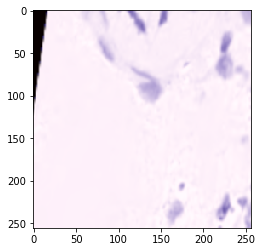

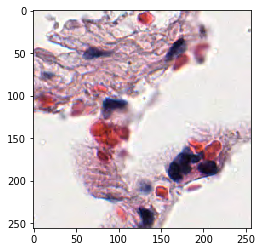

../data/IHC_H_channel/MDA LUAD-18 CD8 Tumor Microenviroment Prospect ADC-028.svs_2.png
../data/HE_unlabeled_40X/9732.svs_37.png
None


In [5]:
indexes_A = ihc_h_indexes_train
indexes_B = he_labeled_train + he_unlabeled

# Generator
train_set = Dataset(indexes_A, indexes_B, image_dict, augmentation=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=2, shuffle=True, num_workers=1, 
                                          collate_fn=collate_fn)
for data in train_loader:
    plt.imshow(normalize(np.transpose(data[0]['A'].numpy(), (1, 2, 0)), inverse=True))
    plt.show()
    plt.imshow(normalize(np.transpose(data[0]['B'].numpy(), (1, 2, 0)), inverse=True))
    plt.show()
    print(data[0]['A_paths'])
    print(data[0]['B_paths'])
    print(data[0]['target_B'])
    break

# 3) Create model

In [6]:
from collections import OrderedDict
import warnings

import torch
from torch import nn, Tensor
from torch.jit.annotations import Tuple, List, Dict, Optional
import torch.nn.functional as F
import torchvision.models.detection as tmdet

from torch_layers import deep_update, BoxPredictor, MaskPredictor, KeypointPredictor

class TransferRCNN(nn.Module):
    """
    MaskRCNN for segmentation and style transfer.
    Arguments:
        backbone (nn.Module):
        rpn (nn.Module):
        roi_heads (nn.Module): takes the features + the proposals from the RPN and computesdetections / masks from it.
        transform (nn.Module): performs the data transformation from the inputs to feed into the model & postprocess.
    """

    def __init__(self, backbone, num_classes, masks=False, keypoints=None, 
                 config={}, pretrained=False):
        super(TransferRCNN, self).__init__()
        self.config = self.default_config(num_classes, masks, keypoints)
        deep_update(self.config, config)
        self.config['featmap_names'] = self.config['featmap_names'] or backbone.featmap_names
        self.config['in_channels'] = self.config['in_channels'] or backbone.out_channels
        
        self.rpn = self.get_rpn()
        self.roi_heads = self.get_roi_heads()
        self.transfer_heads = self.get_transfer_heads()
        self.transform = self.get_transform()
        self.backbone = backbone
        # used only on torchscript mode
        self._has_warned = False
        
        if pretrained:
            self.load_pretrain(pretrained)

    @torch.jit.unused
    def eager_outputs(self, losses, detections, transfered_images):
        # type: (Dict[str, Tensor], List[Dict[str, Tensor]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
        if self.training:
            return losses

        return detections, transfered_images

    def forward(self, images, targets=None):
        # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
        """
        Arguments:
            images (list[Tensor]): images to be processed
            targets (list[Dict[Tensor]]): ground-truth boxes present in the image (optional)
        Returns:
            result (list[BoxList] or dict[Tensor]): the output from the model.
                During training, it returns a dict[Tensor] which contains the losses.
                During testing, it returns list[BoxList] contains additional fields
                like `scores`, `labels` and `mask` (for Mask R-CNN models).
        """
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")
        if self.training:
            assert targets is not None
            for target in targets:
                boxes = target["boxes"]
                if isinstance(boxes, torch.Tensor):
                    if len(boxes.shape) != 2 or boxes.shape[-1] != 4:
                        raise ValueError("Expected target boxes to be a tensor"
                                         "of shape [N, 4], got {:}.".format(
                                             boxes.shape))
                else:
                    raise ValueError("Expected target boxes to be of type "
                                     "Tensor, got {:}.".format(type(boxes)))

        original_image_sizes = torch.jit.annotate(List[Tuple[int, int]], [])
        for img in images:
            val = img.shape[-2:]
            assert len(val) == 2
            original_image_sizes.append((val[0], val[1]))

        images, targets = self.transform(images, targets)

        # Check for degenerate boxes
        # TODO: Move this to a function
        if targets is not None:
            for target_idx, target in enumerate(targets):
                boxes = target["boxes"]
                degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
                if degenerate_boxes.any():
                    # print the first degenrate box
                    bb_idx = degenerate_boxes.any(dim=1).nonzero().view(-1)[0]
                    degen_bb: List[float] = boxes[bb_idx].tolist()
                    raise ValueError("All bounding boxes should have positive height and width."
                                     " Found invaid box {} for target at index {}."
                                     .format(degen_bb, target_idx))

        features = self.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([('0', features)])
        proposals, proposal_losses = self.rpn(images, features, targets)
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        transfered_images = self.transfer_heads(features['0'])
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)

        if torch.jit.is_scripting():
            if not self._has_warned:
                warnings.warn("RCNN always returns a (Losses, Detections) tuple in scripting")
                self._has_warned = True
            return (losses, detections, transfered_images)
        else:
            return (losses, detections, transfered_images)
            # return self.eager_outputs(losses, detections, transfered_images)
    
    def get_transform(self):
        return tmdet.transform.GeneralizedRCNNTransform(**self.config['transform'])
    
    def get_rpn(self):
        in_channels = self.config['in_channels']
        rpn_params = self.config['rpn_params']
        
        rpn_anchor = tmdet.rpn.AnchorGenerator(**rpn_params['anchor'])
        rpn_header = tmdet.rpn.RPNHead(in_channels, rpn_anchor.num_anchors_per_location()[0])
        rpn = tmdet.rpn.RegionProposalNetwork(rpn_anchor, rpn_header, **rpn_params['rpn'])
        
        return rpn
    
    def get_roi_heads(self):
        featmap_names = self.config['featmap_names']
        in_channels = self.config['in_channels']
        roi_params = self.config['roi_params']
        
        ## box header
        box_header = BoxPredictor(in_channels, featmap_names, **roi_params['box'])
        
        ## roi heads
        roi_heads = tmdet.roi_heads.RoIHeads(
            box_roi_pool=box_header.box_roi_pool,
            box_head=box_header.box_head,
            box_predictor=box_header.box_predictor,
            **roi_params['roi']
        )
        
        ## add mask header
        if 'mask' in roi_params:
            mask_header = MaskPredictor(in_channels, featmap_names, **roi_params['mask'])
            roi_heads.mask_roi_pool = mask_header.mask_roi_pool
            roi_heads.mask_head = mask_header.mask_head
            roi_heads.mask_predictor = mask_header.mask_predictor
        
        ## add keypoint header
        if 'keypoint' in roi_params:
            keypoint_header = KeypointPredictor(in_channels, featmap_names, **roi_params['keypoint'])
            roi_heads.keypoint_roi_pool = keypoint_header.keypoint_roi_pool
            roi_heads.keypoint_head = keypoint_header.keypoint_head
            roi_heads.keypoint_predictor = keypoint_header.keypoint_predictor
        
        return roi_heads
    
    def get_transfer_heads(self):
        fpn_channels = self.config['fpn_params']['out_channels']
        transfer_params = self.config['transfer_params']
        return TransferHead(fpn_channels, **transfer_params)
        
    
    def load_pretrain(self, pretrained):
        if isinstance(pretrained, str):
            weights = torch.load(pretrained)
        else:
            if self.roi_heads.has_mask():
                m = tmdet.maskrcnn_resnet50_fpn(
                    pretrained=True, progress=False, pretrained_backbone=False)
            elif self.roi_heads.has_keypoint():
                m = tmdet.keypointrcnn_resnet50_fpn(
                    pretrained=True, progress=False, pretrained_backbone=False)
            else:
                m = tmdet.fasterrcnn_resnet50_fpn(
                    pretrained=True, progress=False, pretrained_backbone=False)
            weights = m.state_dict()
        
        try:
            # remove backbone from state_dict
            w = {k: v for k, v in weights.items() 
                 if not k.startswith('backbone.body')}
            self.load_state_dict(w, strict=False)
        except RuntimeError as e:
            print(e)

    def default_config(self, num_classes, masks, keypoints):
        config = {
            ## backbone
            'featmap_names': None,
            'in_channels': None,
            ## fpn
            'fpn_params':{
                'out_channels': 256,
            },
            ## rpn
            'rpn_params': {
                'anchor': {
                    'sizes': [[32], [64], [128], [256], [512]],
                    'aspect_ratios': [[0.5, 1.0, 2.0]] * 5,
                }, 
                'rpn': {
                    'fg_iou_thresh': 0.7, 
                    'bg_iou_thresh': 0.3,
                    'batch_size_per_image': 256, 
                    'positive_fraction': 0.5,

                    'pre_nms_top_n': {'training': 2000, 'testing': 1000},
                    'post_nms_top_n': {'training': 2000, 'testing': 1000},
                    'nms_thresh': 0.7,
                },
            },
            ## roi
            'roi_params': {
                ## roi predictor
                'roi': {
                    # Faster R-CNN training
                    'fg_iou_thresh': 0.5, 
                    'bg_iou_thresh': 0.5,
                    'batch_size_per_image': 512, 
                    'positive_fraction': 0.25,
                    'bbox_reg_weights': None,
                    # Faster R-CNN inference
                    'score_thresh': 0.05, 
                    'nms_thresh': 0.5, 
                    'detections_per_img': 100,
                },
                ## box predictor
                'box': {
                    'num_classes': num_classes,
                    'roi_output_size': 7, 
                    'roi_sampling_ratio': 2,
                    'layers': [1024, 1024], 
                },
            },
            ## transfer
            'transfer_params':{
                'in_channels': 64,
                'out_channels': 3,
                'up_scales': [2, 2],
            },
            ## transform
            'transform': {
                'min_size': 800, 'max_size': 1333, 
                'image_mean': [0.485, 0.456, 0.406], 'image_std': [0.229, 0.224, 0.225],
            }
        }
        if masks:
            ## mask predictor
            config['roi_params']['mask'] = {
                'num_classes': num_classes,
                'roi_output_size': 14, 
                'roi_sampling_ratio': 2,
                'layers': [256, 256, 256, 256],
                'dilation': 1,
                'dim_reduced': 256,
            }
        if keypoints:
            ## keypoint predictor
            config['roi_params']['keypoint'] = {
                'num_keypoints': keypoints,
                'roi_output_size': 14, 
                'roi_sampling_ratio': 2,
                'layers': [512] * 8,
            }

        return config
    
class TransferHead(nn.Module):
    def __init__(self, fpn_channels, in_channels, out_channels, up_scales):
        super(TransferHead, self).__init__()
        transfer_block = [nn.Conv2d(fpn_channels, in_channels, kernel_size=1, padding=0)]
        transfer_block.extend([UpsampleBLock(in_channels, up_scale) for up_scale in up_scales])
        transfer_block.append(nn.Conv2d(in_channels, out_channels, kernel_size=9, padding=4))
        self.transfer_block = nn.Sequential(*transfer_block)
        self.mse_loss = nn.MSELoss()
    
    def forward(self, x, targets=None):
        x = self.transfer_block(x)
        x = (F.tanh(x) + 1)/2
        
        '''
        losses = {}
        if self.training:
            assert targets is not None
            losses = {
                "loss_transfer_image": self.mse_loss(x, targets),
            }
        '''
        return x
    
class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.bn = nn.BatchNorm2d(in_channels)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

In [7]:
## Model Config
MODEL_CONFIG = {
    'transform': {
        'min_size': 256, 'max_size': 256, 
        'image_mean': [0.0, 0.0, 0.0], 'image_std': [1.0, 1.0, 1.0],
    }
}

In [8]:
import torch
import itertools
from util.image_pool import ImagePool

# Self defined functions
from base_model import BaseModel
import networks


class SegCycleGANModel(BaseModel):
    """
    This class implements the SegCycleGAN model, for learning image-to-image translation without paired data 
    and learning segmentation at the same time.
    The model training requires '--dataset_mode unaligned' dataset.
    By default, it uses a '--netG resnet_9blocks' ResNet generator,
    a '--netD basic' discriminator (PatchGAN introduced by pix2pix),
    and a least-square GANs objective ('--gan_mode lsgan').
    CycleGAN paper: https://arxiv.org/pdf/1703.10593.pdf
    """
    @staticmethod
    def modify_commandline_options(parser, is_train=True):
        """Add new dataset-specific options, and rewrite default values for existing options.
        Parameters:
            parser          -- original option parser
            is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or 
                               test-specific options.
        Returns:
            the modified parser.
        For CycleGAN, in addition to GAN losses, we introduce lambda_A, lambda_B, and lambda_identity for the following losses.
        A (source domain), B (target domain).
        Generators: G_A: A -> B; G_B: B -> A.
        Discriminators: D_A: G_A(A) vs. B; D_B: G_B(B) vs. A.
        Forward cycle loss:  lambda_A * ||G_B(G_A(A)) - A|| (Eqn. (2) in the paper)
        Backward cycle loss: lambda_B * ||G_A(G_B(B)) - B|| (Eqn. (2) in the paper)
        Identity loss (optional): lambda_identity * (||G_A(B) - B|| * lambda_B + ||G_B(A) - A|| * lambda_A) 
                                  (Sec 5.2 "Photo generation from paintings" in the paper)
        Dropout is not used in the original CycleGAN paper.
        """
        parser.set_defaults(no_dropout=True)  # default CycleGAN did not use dropout
        if is_train:
            parser.add_argument('--lambda_A', type=float, default=10.0, help='weight for cycle loss (A -> B -> A)')
            parser.add_argument('--lambda_B', type=float, default=10.0, help='weight for cycle loss (B -> A -> B)')
            parser.add_argument('--lambda_identity', type=float, default=0.5, help='''use identity mapping. 
Setting lambda_identity other than 0 has an effect of scaling the weight of the 
identity mapping loss. For example, if the weight of the identity loss should be 
10 times smaller than the weight of the reconstruction loss, please set lambda_identity = 0.1''')

        return parser

    def __init__(self, opt, threshold):
        """Initialize the CycleGAN class.
        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
            threshold: threshold for filtering out low confidence objects
        """
        BaseModel.__init__(self, opt)
        self.threshold = threshold
        
        # specify the training losses you want to print out. The training/test scripts will call <BaseModel.get_current_losses>
        self.loss_names = ['D_A', 'G_A', 'cycle_A', 'idt_A', 'D_B', 'G_B', 'cycle_B', 'idt_B']
        # specify the images you want to save/display. The training/test scripts will call <BaseModel.get_current_visuals>
        visual_names_A = ['real_A', 'fake_B', 'rec_A']
        visual_names_B = ['real_B', 'fake_A', 'rec_B']
        if self.isTrain and self.opt.lambda_identity > 0.0:  # if identity loss is used, we also visualize idt_B=G_A(B) ad idt_A=G_A(B)
            visual_names_A.append('idt_B')
            visual_names_B.append('idt_A')

        self.visual_names = visual_names_A + visual_names_B  # combine visualizations for A and B
        # specify the models you want to save to the disk. 
        # The training/test scripts will call <BaseModel.save_networks> and <BaseModel.load_networks>.
        if self.isTrain:
            self.model_names = ['G_A', 'G_B', 'D_A', 'D_B']
        else:  # during test time, only load Gs
            self.model_names = ['G_A', 'G_B']

        # define networks (both Generators and discriminators)
        resnet_fpn_A = tmdet.backbone_utils.resnet_fpn_backbone('resnet50', pretrained=True)
        resnet_fpn_A.featmap_names = ['0', '1', '2', '3']
        resnet_fpn_B = tmdet.backbone_utils.resnet_fpn_backbone('resnet50', pretrained=True)
        resnet_fpn_B.featmap_names = ['0', '1', '2', '3']
        self.netG_A = TransferRCNN(resnet_fpn_A, num_classes=len(CLASSES)+1, masks=True, config=MODEL_CONFIG, pretrained=True)
        self.netG_B = TransferRCNN(resnet_fpn_B, num_classes=len(CLASSES)+1, masks=True, config=MODEL_CONFIG, pretrained=True)
        self.netG_A = self.netG_A.to(self.gpu_ids[0])
        self.netG_B = self.netG_B.to(self.gpu_ids[0])

        if self.isTrain:  # define discriminators
            self.netD_A = networks.define_D(opt.output_nc, opt.ndf, opt.netD,
                                            opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)
            self.netD_B = networks.define_D(opt.input_nc, opt.ndf, opt.netD,
                                            opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)

        if self.isTrain:
            if opt.lambda_identity > 0.0:  # only works when input and output images have the same number of channels
                assert(opt.input_nc == opt.output_nc)
            self.fake_A_pool = ImagePool(opt.pool_size)  # create image buffer to store previously generated images
            self.fake_B_pool = ImagePool(opt.pool_size)  # create image buffer to store previously generated images
            # define loss functions
            self.criterionGAN = networks.GANLoss(opt.gan_mode).to(self.device)  # define GAN loss.
            self.criterionCycle = torch.nn.L1Loss()
            self.criterionIdt = torch.nn.L1Loss()
            # initialize optimizers; schedulers will be automatically created by function <BaseModel.setup>.
            self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()), 
                                                lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_A.parameters(), self.netD_B.parameters()), 
                                                lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D)

    def set_input(self, data):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.
        Parameters:
            input (dict): include the data itself and its metadata information.
        The option 'direction' can be used to swap domain A and domain B.
        A: IHC
        B: HE
        """
        AtoB = self.opt.direction == 'AtoB'
        self.real_A = torch.stack([_['A' if AtoB else 'B'] for _ in data]).float().to(self.device)
        self.real_B = torch.stack([_['B' if AtoB else 'A'] for _ in data]).float().to(self.device)
        self.image_paths = [_['A_paths' if AtoB else 'B_paths'] for _ in data]
        for _ in data:
            if _['target_B'] is not None:
                for key in list(_['target_B'].keys()):
                    _['target_B'][key] = _['target_B'][key].to(self.device)
        self.target_B = [_['target_B'] for _ in data]

    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        self.netG_B.eval()
        self.netG_A.eval()
        _, _, self.fake_B = self.netG_A(self.real_A)
        _, self.target_A, _ = self.netG_B(self.fake_B)
        for i, _ in enumerate(self.target_A):
            self.target_A[i] = self.filter_detections(_)
        for i, _ in enumerate(self.target_B):
            if _ is None:
                _, _temp_target_B, _ = self.netG_B(self.real_B[i:i+1, ...])
                _temp_target_B = self.filter_detections(_temp_target_B[0])
                self.target_B[i] = _temp_target_B
        
        self.netG_A.train()
        self.netG_B.train()
        # Only use mask_loss_real_A & mask_loss_real_B & mask_loss_fake_A
        self.mask_loss_real_A, self.mask_pred_real_A, self.fake_B = self.netG_A(self.real_A, self.target_A)
        self.mask_loss_fake_B, self.mask_pred_fake_B, self.rec_A = self.netG_B(self.fake_B, self.target_A)
        self.mask_loss_real_B, self.mask_pred_real_B, self.fake_A = self.netG_B(self.real_B, self.target_B)
        self.mask_loss_fake_A, self.mask_pred_fake_A, self.rec_B = self.netG_A(self.fake_A, self.target_B)

    def backward_D_basic(self, netD, real, fake, val=False):
        """Calculate GAN loss for the discriminator
        Parameters:
            netD (network)      -- the discriminator D
            real (tensor array) -- real images
            fake (tensor array) -- images generated by a generator
        Return the discriminator loss.
        We also call loss_D.backward() to calculate the gradients.
        """
        # Real
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        # Fake
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        # Combined loss and calculate gradients
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        if not val:
            loss_D.backward()
        return loss_D

    def backward_D_A(self, val=False):
        """Calculate GAN loss for discriminator D_A"""
        fake_B = self.fake_B_pool.query(self.fake_B)
        self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, fake_B, val=val)

    def backward_D_B(self, val=False):
        """Calculate GAN loss for discriminator D_B"""
        fake_A = self.fake_A_pool.query(self.fake_A)
        self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, fake_A, val=val)

    def backward_G(self, val=False):
        """Calculate the loss for generators G_A and G_B"""
        lambda_idt = self.opt.lambda_identity
        lambda_A = self.opt.lambda_A
        lambda_B = self.opt.lambda_B
        # Identity loss
        if lambda_idt > 0:
            # G_A should be identity if real_B is fed: ||G_A(B) - B||
            _, _, self.idt_A = self.netG_A(self.real_B, self.target_B)
            self.loss_idt_A = self.criterionIdt(self.idt_A, self.real_B) * lambda_B * lambda_idt
            # G_B should be identity if real_A is fed: ||G_B(A) - A||
            _, _, self.idt_B = self.netG_B(self.real_A, self.target_A)
            self.loss_idt_B = self.criterionIdt(self.idt_B, self.real_A) * lambda_A * lambda_idt
        else:
            self.loss_idt_A = 0
            self.loss_idt_B = 0

        # GAN loss D_A(G_A(A))
        self.loss_G_A = self.criterionGAN(self.netD_A(self.fake_B), True)
        # GAN loss D_B(G_B(B))
        self.loss_G_B = self.criterionGAN(self.netD_B(self.fake_A), True)
        # Forward cycle loss || G_B(G_A(A)) - A||
        self.loss_cycle_A = self.criterionCycle(self.rec_A, self.real_A) * lambda_A
        # Backward cycle loss || G_A(G_B(B)) - B||
        self.loss_cycle_B = self.criterionCycle(self.rec_B, self.real_B) * lambda_B
        # combined loss and calculate gradients
        self.loss_G = self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B + self.loss_idt_A + self.loss_idt_B + \
                        sum(loss for loss in self.mask_loss_real_B.values()) + \
                        sum(loss for loss in self.mask_loss_fake_A.values()) + sum(loss for loss in self.mask_loss_real_A.values())
        
        if not val:
            self.loss_G.backward()

    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        # forward
        self.forward()      # compute fake images and reconstruction images.
        # G_A and G_B
        self.set_requires_grad([self.netD_A, self.netD_B], False)  # Ds require no gradients when optimizing Gs
        self.optimizer_G.zero_grad()  # set G_A and G_B's gradients to zero
        self.backward_G()             # calculate gradients for G_A and G_B
        self.optimizer_G.step()       # update G_A and G_B's weights
        # D_A and D_B
        self.set_requires_grad([self.netD_A, self.netD_B], True)
        self.optimizer_D.zero_grad()   # set D_A and D_B's gradients to zero
        self.backward_D_A()      # calculate gradients for D_A
        self.backward_D_B()      # calculate graidents for D_B
        self.optimizer_D.step()  # update D_A and D_B's weights
        
    def forward_wo_optimize_parameters(self):
        """Calculate losses in validation set, run within torch.no_grad()"""
        # forward
        self.forward()
        
        # G_A and G_B
        self.backward_G(val=True)
        
        # D_A and D_B
        self.backward_D_A(val=True)      # calculate gradients for D_A
        self.backward_D_B(val=True) 
        
    def save_networks(self, epoch):
        """Save all the networks to the disk.
        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = '%s_net_%s.pth' % (epoch, name)
                save_path = os.path.join(self.save_dir, save_filename)
                net = getattr(self, 'net' + name)

                if isinstance(net, torch.nn.DataParallel):
                    torch.save(net.module.state_dict(), save_path)
                else:
                    torch.save(net.state_dict(), save_path)

    def load_networks(self, epoch):
        """Load all the networks from the disk.
        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                load_filename = '%s_net_%s.pth' % (epoch, name)
                load_path = os.path.join(self.save_dir, load_filename)
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                print('loading the model from %s' % load_path)
                # if you are using PyTorch newer than 0.4 (e.g., built from
                # GitHub source), you can remove str() on self.device
                state_dict = torch.load(load_path, map_location=str(self.device))
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata

                # patch InstanceNorm checkpoints prior to 0.4
                # for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                #     self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
                net.load_state_dict(state_dict)
                
    def filter_detections(self, det):
        """Filter out maskrcnn detetions with low confidence."""
        if 'scores' in det.keys():
            _scores = det['scores']
            if torch.sum(_scores > self.threshold) > 0:
                det['boxes'] = torch.stack([det['boxes'][i, ...] for i in range(len(_scores)) 
                                            if _scores[i] >= self.threshold]).to(self.device).detach()
                det['labels'] = torch.stack([det['labels'][i, ...] for i in range(len(_scores))
                                             if _scores[i] >= self.threshold]).to(self.device).detach()
                det['masks'] = torch.as_tensor(torch.stack([det['masks'][i, ...] > 0.55 for i in range(len(_scores)) 
                                            if _scores[i] >= self.threshold]), dtype=torch.uint8).to(self.device).detach()
                if len(det['masks'].size()) == 4:
                    det['masks'] = det['masks'][:, 0, ...].to(self.device)
                det['scores'] = torch.stack([_ for _ in _scores if _ >= self.threshold]).to(self.device).detach()
            else:
                det['boxes'] = torch.empty(0, 4, dtype=torch.float32).to(self.device)
                det['labels'] = torch.tensor([], dtype=torch.int64).to(self.device)
                det['masks'] = torch.empty(0, 1, opt.crop_size, opt.crop_size, dtype=torch.uint8).to(self.device)
                det['scores'] = torch.tensor([], dtype=torch.float32).to(self.device)
        return det

In [9]:
import time
from options.train_options import TrainOptions

opt = TrainOptions().parse(['--dataroot', '.', 
                            '--batch_size', '5', 
                            '--checkpoints_dir', './models',
                            '--name', "curriculum_256_09082020", 
                            '--print_freq', '30', 
                            '--lr', '0.00002', 
                            '--epoch_count', '1',
                            '--n_epochs', '1000'], SegCycleGANModel)

----------------- Options ---------------
               batch_size: 5                             	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./models                      	[default: ./checkpoints]
           continue_train: False                         
                crop_size: 256                           
                 dataroot: .                             	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest 

In [10]:
# Create model dir
if not os.path.exists(os.path.join(opt.checkpoints_dir, opt.name)):
    os.mkdir(opt.checkpoints_dir)

model = SegCycleGANModel(opt, threshold=0.05)
model.setup(opt)

# Load model
epoch = 500
load_dir = "./models/curriculum_256_08122020/"
for name in model.model_names:
    if isinstance(name, str):
        load_filename = '%s_net_%s.pth' % (epoch, name)
        load_path = os.path.join(load_dir, load_filename)
        net = getattr(model, 'net' + name)
        if isinstance(net, torch.nn.DataParallel):
            net = net.module
        print('loading the model from %s' % load_path)
        # if you are using PyTorch newer than 0.4 (e.g., built from
        # GitHub source), you can remove str() on self.device
        state_dict = torch.load(load_path, map_location=str(model.device))
        if hasattr(state_dict, '_metadata'):
            del state_dict._metadata
        net.load_state_dict(state_dict)

Error(s) in loading state_dict for TransferRCNN:
	size mismatch for roi_heads.box_predictor.cls_score.weight: copying a param with shape torch.Size([91, 1024]) from checkpoint, the shape in current model is torch.Size([7, 1024]).
	size mismatch for roi_heads.box_predictor.cls_score.bias: copying a param with shape torch.Size([91]) from checkpoint, the shape in current model is torch.Size([7]).
	size mismatch for roi_heads.box_predictor.bbox_pred.weight: copying a param with shape torch.Size([364, 1024]) from checkpoint, the shape in current model is torch.Size([28, 1024]).
	size mismatch for roi_heads.box_predictor.bbox_pred.bias: copying a param with shape torch.Size([364]) from checkpoint, the shape in current model is torch.Size([28]).
	size mismatch for roi_heads.mask_predictor.mask_fcn_logits.weight: copying a param with shape torch.Size([91, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([7, 256, 1, 1]).
	size mismatch for roi_heads.mask_predictor.mask_fcn_

# 4) Train

In [12]:
def display(image, targets, show_ori=False, label_to_val=LABEL_TO_RGB, threshold=0.0):
    """
    Args:
        image: range 0-1, 3 channels
    """
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).detach().cpu().numpy()
    if targets is not None:
        bboxes = targets['boxes']
        labels = targets['labels']
        masks = targets['masks']
        scores = None
        if 'scores' in list(targets.keys()):
            scores = targets['scores']
        if isinstance(bboxes, torch.Tensor):
            bboxes = bboxes.detach().cpu().numpy()
        if isinstance(labels, torch.Tensor):
            labels = labels.detach().cpu().numpy()
        if isinstance(masks, torch.Tensor):
            masks = masks.detach().cpu().numpy()
        if isinstance(scores, torch.Tensor):
            scores = scores.detach().cpu().numpy()
        if len(masks.shape) == 4:
            masks = masks[:, 0, ...]
        
        # Remove according to threshold
        if scores is not None:
            bboxes = [_ for i, _ in enumerate(bboxes) if scores[i] >= threshold]
            labels = [_ for i, _ in enumerate(labels) if scores[i] >= threshold]
            masks = [_ for i, _ in enumerate(masks) if scores[i] >= threshold]
    
    if show_ori:
        fig, ax = plt.subplots(1, 2, figsize=(6 * 2, 6))
        ax[0].imshow(np.array(np.clip(image * 255, 0, 255), dtype=np.uint8))
        ax[1].imshow(np.array(np.clip(image * 255, 0, 255), dtype=np.uint8))
        if targets is not None:
            color = label_to_val
            for i, (mask, bbox, label) in enumerate(zip(masks, bboxes, labels)):
                c = tuple([1.0*_/255 for _ in color[label]]) if label else (0, 0, 0)
                polygon = binary_mask_to_polygon(mask)
                for verts in polygon:
                    p = Polygon(np.array(verts[:, ::-1]), facecolor="none", edgecolor=c)
                    ax[1].add_patch(p)
                y1, x1, y2, x2 = bbox
                b = Rectangle((y1, x1), (y2-y1), (x2-x1), linewidth=2,
                              alpha=0.5, linestyle="solid", edgecolor=c, facecolor="none")
                ax[1].add_patch(b)
    else:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(np.array(np.clip(image * 255, 0, 255), dtype=np.uint8))
        if targets is not None:
            color = label_to_val
            for i, (mask, bbox, label) in enumerate(zip(masks, bboxes, labels)):
                c = tuple([1.0*_/255 for _ in color[label]]) if label else (0, 0, 0)
                polygon = binary_mask_to_polygon(mask)
                for verts in polygon:
                    p = Polygon(np.array(verts[:, ::-1]), facecolor="none", edgecolor=c)
                    ax.add_patch(p)
                y1, x1, y2, x2 = bbox
                b = Rectangle((y1, x1), (y2-y1), (x2-x1), linewidth=2,
                              alpha=0.5, linestyle="solid", edgecolor=c, facecolor="none")
                ax.add_patch(b)
                
                if scores is not None:
                    score = scores[i]
                    ax.text(y1, x2, np.round(score, 2), color=(1, 1, 1))

    plt.show()

In [13]:
def train(model, train_loader, opt, epoch, loss_names):
    print("Train epoch {}".format(epoch))
    hist = dict()
    for loss_name in loss_names:
        hist[loss_name] = []
    
    for i, data in enumerate(train_loader):
        # Forward and backward
        model.set_input(data)
        model.optimize_parameters()
        
        # Update hist
        for loss_name in loss_names:
            loss = getattr(model, loss_name)
            if isinstance(loss, dict):
                for key in list(loss.keys()):
                    loss[key] = loss[key].item()
                if hist[loss_name] == []:
                    hist[loss_name] = dict()
                    for key in list(loss.keys()):
                        hist[loss_name][key] = []
                for key in list(loss.keys()):
                    hist[loss_name][key].append(loss[key])
            else:
                hist[loss_name].append(loss.item())
        
        if (i + 1) % opt.print_freq == 0:
            to_print = ""
            for loss_name in loss_names:
                if isinstance(hist[loss_name], dict):
                    for key in list(hist[loss_name].keys()):
                        to_print += loss_name + "_" + key + " " + str(np.round(np.average(hist[loss_name][key]), 3))
                        to_print += "\t"
                else:
                    to_print += loss_name + " " + str(np.round(np.average(hist[loss_name]), 3))
                    to_print += "\t"
            print(to_print)
    
    for loss_name in loss_names:
        if isinstance(hist[loss_name], dict):
            for key in list(hist[loss_name].keys()):
                hist[loss_name][key] = np.average(hist[loss_name][key])
        else:
            hist[loss_name] = np.average(hist[loss_name])
                
    return hist

def val(model, val_loader, opt, epoch, loss_names):
    print("Val epoch {}".format(epoch))
    hist = dict()
    for loss_name in loss_names:
        hist[loss_name] = []
    
    for i, data in enumerate(val_loader):
        with torch.no_grad():
            # Forward
            model.set_input(data)
            model.forward_wo_optimize_parameters()
        
        # Update hist
        for loss_name in loss_names:
            loss = getattr(model, loss_name)
            if isinstance(loss, dict):
                for key in list(loss.keys()):
                    loss[key] = loss[key].item()
                if hist[loss_name] == []:
                    hist[loss_name] = dict()
                    for key in list(loss.keys()):
                        hist[loss_name][key] = []
                for key in list(loss.keys()):
                    hist[loss_name][key].append(loss[key])
            else:
                hist[loss_name].append(loss.item())
    
    to_print = ""
    for loss_name in loss_names:
        if isinstance(hist[loss_name], dict):
            for key in list(hist[loss_name].keys()):
                hist[loss_name][key] = np.average(hist[loss_name][key])
                to_print += loss_name + "_" + key + " " + str(np.round(hist[loss_name][key], 3))
                to_print += "\t"
        else:
            hist[loss_name] = np.average(hist[loss_name])
            to_print += loss_name + " " + str(np.round(hist[loss_name], 3))
            to_print += "\t"
    print(to_print)
                
    return hist

In [14]:
# Generator
indexes_A = ihc_h_indexes_train
indexes_B = he_labeled_train + he_unlabeled_indexes_train

train_set = Dataset(ihc_h_indexes_train, indexes_B, image_dict, augmentation=True, crop_size=opt.crop_size)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=opt.batch_size, shuffle=True, num_workers=10, 
                                          collate_fn=collate_fn)
val_set = Dataset(ihc_h_indexes_val, he_labeled_val + he_unlabeled_indexes_val, image_dict, augmentation=False, 
                 crop_size=opt.crop_size)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=opt.batch_size, shuffle=True, num_workers=10, 
                                          collate_fn=collate_fn)

In [15]:
# History
loss_names = ["loss_G", "loss_G_A", "loss_G_B", 
              "loss_cycle_A", "loss_cycle_B", 
              "loss_idt_A", "loss_idt_B",
              "loss_D_A", "loss_D_B", 
              "mask_loss_real_A", "mask_loss_real_B", "mask_loss_fake_A"]
hist = dict()
for loss_name in loss_names:
    hist[loss_name] = []
    hist[loss_name+"_val"] = []

In [ ]:
for epoch in range(opt.epoch_count, 601): 
    epoch_start_time = time.time()
    
    hist_epoch = train(model, train_loader, opt, epoch, loss_names)
    for loss_name in loss_names:
        if isinstance(hist_epoch[loss_name], dict):
            if hist[loss_name] == []:
                hist[loss_name] = dict()
                for key in list(hist_epoch[loss_name].keys()):
                    hist[loss_name][key] = []
            for key in list(hist_epoch[loss_name].keys()):
                hist[loss_name][key].append(hist_epoch[loss_name][key])
        else:
            hist[loss_name].append(hist_epoch[loss_name])
    
    hist_epoch = val(model, val_loader, opt, epoch, loss_names)
    for loss_name in loss_names:
        if isinstance(hist_epoch[loss_name], dict):
            if hist[loss_name+"_val"] == []:
                hist[loss_name+"_val"] = dict()
                for key in list(hist_epoch[loss_name].keys()):
                    hist[loss_name+"_val"][key] = []
            for key in list(hist_epoch[loss_name].keys()):
                hist[loss_name+"_val"][key].append(hist_epoch[loss_name][key])
        else:
            hist[loss_name+"_val"].append(hist_epoch[loss_name])
        
    # Plot
    if epoch % 20 == 0:
        plt.figure(figsize=(12, 12))
        plt.subplot(221)
        plt.imshow(np.transpose(np.array(np.clip(model.real_A[0].detach().cpu().numpy()*255, 0, 255), 
                                                 dtype=np.uint8), (1, 2, 0)))
        plt.title("real IHC")
        plt.subplot(222)
        plt.imshow(np.transpose(np.array(np.clip(model.real_B[0].detach().cpu().numpy()*255, 0, 255), 
                                         dtype=np.uint8), (1, 2, 0)))
        plt.title("real HE")
        plt.subplot(223)
        plt.imshow(np.transpose(np.array(model.fake_B[0].detach().cpu().numpy()*255, dtype=np.uint8), (1, 2, 0)))
        plt.title("fake HE")
        plt.subplot(224)
        plt.imshow(np.transpose(np.array(model.fake_A[0].detach().cpu().numpy()*255, dtype=np.uint8), (1, 2, 0)))
        plt.title("fake IHC")
        plt.show()
        
    if epoch % 20 == 0:
        model.netG_A.eval()
        _, _mask, _ = model.netG_A(model.real_A)
        display(model.real_A[0], _mask[0], threshold=0.05)

        model.netG_B.eval()
        _, _mask, _ = model.netG_B(model.real_B)
        display(model.real_B[0], _mask[0], threshold=0.05)
    
    # Save model
    if epoch % opt.save_epoch_freq == 0:
        model.save_networks(epoch)
        print("Saved model to {}".format(os.path.join(opt.checkpoints_dir, opt.name, str(epoch)+"_..._.pt")))
        
    model.update_learning_rate()

    print('End of epoch %d / %d \t Time Taken: %d sec' %
          (epoch, opt.n_epochs + opt.n_epochs_decay, time.time() - epoch_start_time))

In [17]:
model.save_networks(epoch)
print("Saved model to {}".format(os.path.join(opt.checkpoints_dir, opt.name, str(epoch)+"_..._.pt")))
torch.save(hist, os.path.join(opt.checkpoints_dir, opt.name, "hist_with_more_HE.pt"))

Saved model to ./models/curriculum_256_09082020/600_..._.pt


## Plot learning curve

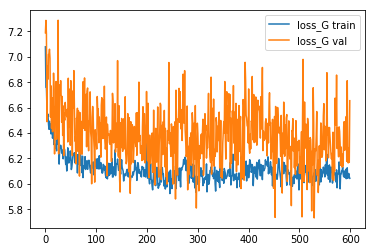

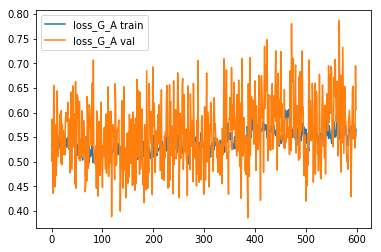

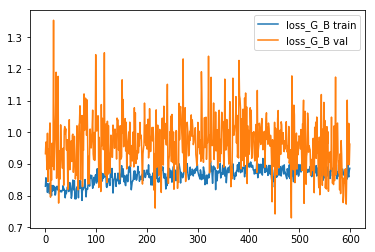

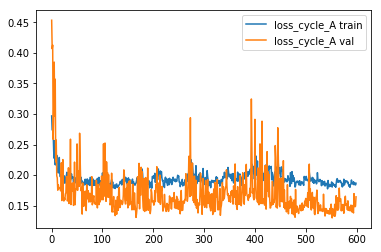

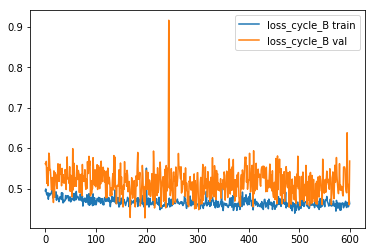

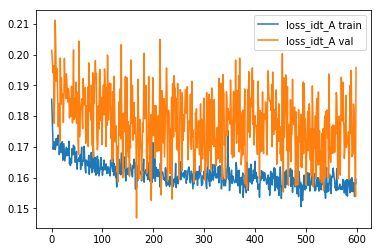

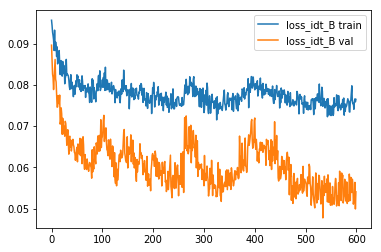

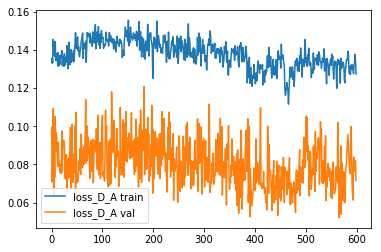

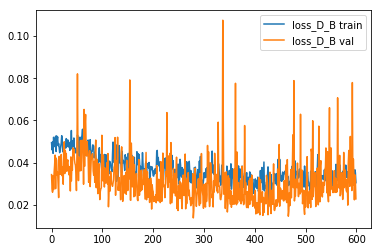

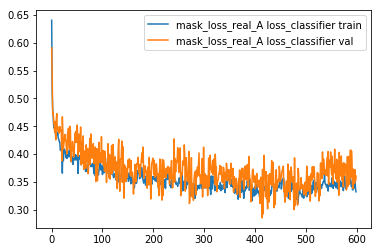

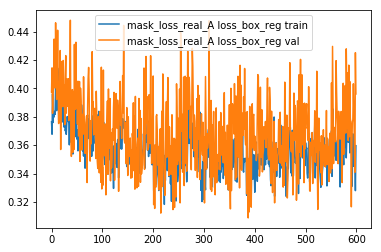

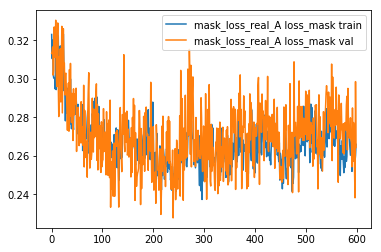

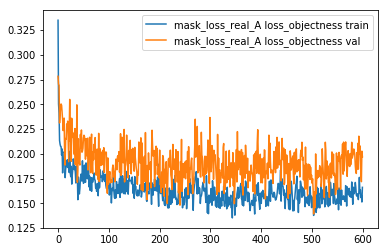

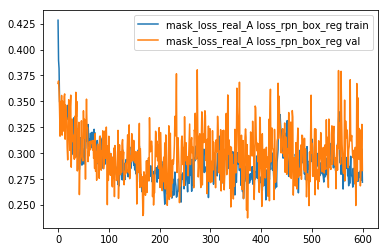

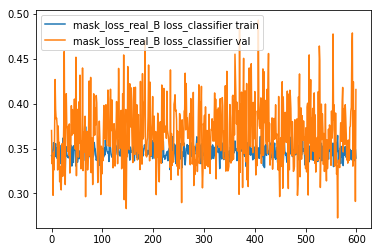

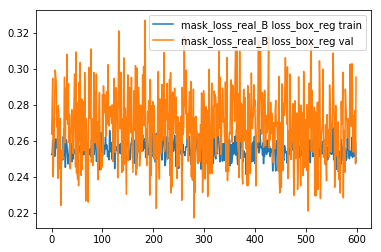

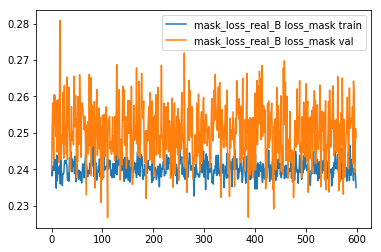

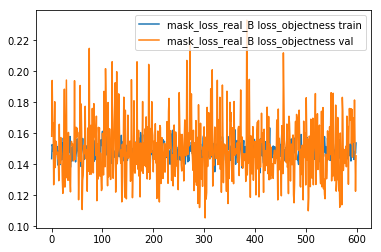

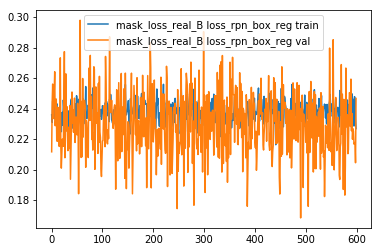

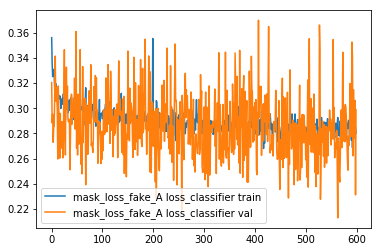

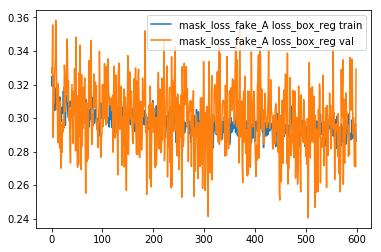

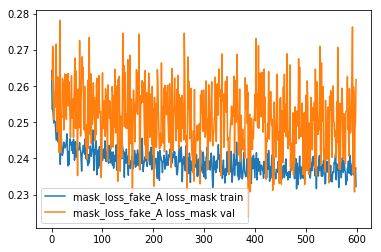

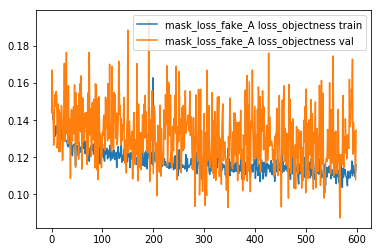

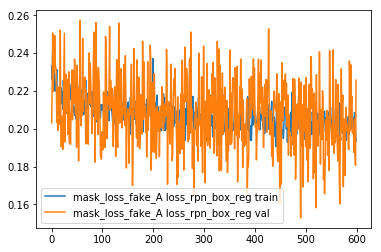

In [18]:
for loss_name in loss_names:
    loss = hist[loss_name]
    if isinstance(loss, dict):
        for key in list(loss.keys()):
            plt.plot(np.arange(len(hist[loss_name][key])), hist[loss_name][key], label=loss_name+" "+key+" train")
            plt.plot(np.arange(len(hist[loss_name][key])), hist[loss_name+"_val"][key], label=loss_name+" "+key+" val")
            plt.legend()
            plt.show()
    else:
        plt.plot(np.arange(len(hist[loss_name])), hist[loss_name], label=loss_name+" train")
        plt.plot(np.arange(len(hist[loss_name])), hist[loss_name+"_val"], label=loss_name+" val")
        plt.legend()
        plt.show()

# Session Info

In [1]:
!pip freeze

absl-py==0.7.0
altair==3.2.0
argh==0.26.2
astor==0.7.1
astropy==3.2.1
atomicwrites==1.3.0
attrs==19.1.0
autograd==1.2
backcall==0.1.0
base58==1.0.3
bleach==1.5.0
blinker==1.4
boto3==1.10.15
botocore==1.13.15
Bottleneck==1.2.1
cachetools==4.1.0
certifi==2019.3.9
chardet==3.0.4
Click==7.0
cvxopt==1.2.3
cvxpy==1.0.24
cycler==0.10.0
Cython==0.29.15
decorator==4.4.0
defusedxml==0.5.0
dill==0.2.9
docutils==0.15.2
ecos==2.0.7.post1
entrypoints==0.3
enum-compat==0.0.3
environment-kernels==1.1.1
FITS-tools==0.2
future==0.17.1
gast==0.2.2
google-auth==1.14.3
google-auth-oauthlib==0.4.1
google-pasta==0.2.0
grpcio==1.29.0
h5py==2.10.0
html5lib==0.9999999
idna==2.8
image-registration==0.2.4
imageio==2.6.1
importlib-metadata==0.23
ipykernel==5.1.0
ipython==7.4.0
ipython-genutils==0.2.0
ipywidgets==7.4.2
isodate==0.6.0
jedi==0.13.3
Jinja2==2.10.1
jmespath==0.9.4
jsonschema==3.0.1
jupyter==1.0.0
jupyter-client==5.2.4
jupyter-console==6.0.0
jupyter-core==4.4.0
Keras==2.3.1
Keras-Applications==1.0.8
Ker